# Linear Regression 

<br>

```{image} images/island_lin_reg.png
:class: bg-primary mb-1
:width: 270px
:align: center
```

<br>

Imagine you are conducting social research on an island with 10,000 people living on it. Imagine further that the citizens of the island use a set of physical credits to represent social status. That is, the amount of social status (or lack thereof) that each islander has is represented in the number of 'prestige credits' that they have in their possession. The prestige credits are awarded by those around them, and by the government of the island.

One of the social scientists in your research team suggests that citizens of the islands who are wealthier attract a higher number of prestige credits. The statistical version of this hypothesis is that `prestige` is postiviely associated with `wealth`. One way of thinking about this statistical hypothesis is that, if you know an islander's `wealth`, then this gives you predictive information about their social status. If you know someone is far above average `wealth`, then, if the hypothesis is true, then it's a safe bet that also have above average `prestige`.

To test this hypothesis, your research team collect `wealth` and `prestige` scores for 1000 citizens of the island. You do this via random sampling. The government of the island has granted the research team access to census data, and so your team were able to use a computer to randomly select 1000 individuals, and survey them to collect the data.

The team contacted the 1000 randomly sampled islanders and asked them to complete a survey recording their `wealth` and `prestige`. The first 20 rows of the dataframe in which the team stored the `prestige` scores are shown below (each row corresponds to one islander). The variables contained in the dataframe are detailed below:

 `prestige` - a discrete numerical variable, the number of prestige credits each islander has.

 `wealth` - a continuous numerical variable, recorded in units of the currency of the island.

In [1]:
# importing some python packages needed for this page
import islands_GLM
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.optimize import minimize

# generating the data for this page
wealth_pop, religion_pop, prestige_pop, df = islands_GLM.prestige_wealth_df()

# making plots look like R!
islands_GLM.r_ify()

# show the data
df[['wealth', 'prestige']]

,wealth,prestige
0,181.35,641
1,178.62,652
2,176.06,689
3,190.41,632
4,166.84,635
...,...,...
995,168.00,558
996,165.21,544
997,139.76,519
998,168.80,525


From inspecting the scatterplot of `wealth` against `prestige` (shown below), your team decide the trend looks roughly linear, and so decide to fit a linear regression model. 

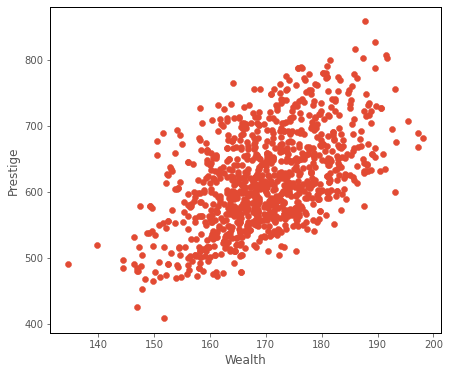

In [2]:
# this code generates the plot below
islands_GLM.plot_prestige_wealth(df['wealth'], df['prestige']);

## Context

Linear regression is (somewhat obviously) the foundational generalized linear model. We have already seen it on the ['What are Generalized Linear Models?'](1_generalized_linear_models.ipynb) page, but now we will delve into how the parameter estimates are obtained, via the conditional distribution (aka maximum likelihood) approach. 

Linear regression is used to model the linear relationship between a quantitative outcome variable and one or more predictor variables. As with all generalized linear models, the predictor variables can be of any type (quantitative-continuous, quantitative-discrete, nominal-categorical, ordinal-categorical).

The predictions from linear regression can range from positive infinity to negative infinity. So if the outcome variable is does not (theoreticall) range from positive to negative infinity, for instance if it must be positive (e.g. number of children), then the model may produce nonsensical predictions. In this case, the outcome variable `prestige` is  quantitative, and judging from the scatterplot, has a mean far from 0. If the mean were close to 0, we might consider fitting a different generalized linear model, as negative predictions may not make sense for `prestige`.

## Model

As shown previously, the prediction equation for the linear regression model is:

$\large \hat{y}_i = b_0 + b_1x_{1i} + ... + b_kx_{ki} $

...where there are $k$ predictor variables, and $n$ observations, where an individual observation is denoted with $i$, and where:

$\hat{y_i} $ : is the predicted value of the outcome variable for a given set of predictor scores, for the $i$th observation

$b_0$ : is the intercept term, the predicted value of the outcome variable when all predictors equal 0

$b_1$ : is the slope of the 1st predictor variable

$x_{1i}$ : is the score on the the first predictor variable, for the $i$th observation

$b_k$ : is the slope of the $k$th predictor variable

$x_{ki}$ : is the score on the $k$th predictor variable, for the $i$th observation


The individual predictions ($\hat{y_i}$), for all $n$ observations, using $k$ variables as predictors are:

$$ \large \hat{y}_1 = b_{0} + b_{1}x1_1 + \dots + b_{k}xk_1 $$

$$ \large \hat{y}_2 = b_{0} + b_{1}x1_2 + \dots + b_{k}xk_2 $$

$$ \large \hat{y}_3 = b_{0} + b_{1}x1_3 + \dots + b_{k}xk_3  $$

$$ \dots $$

$$ \large \hat{y}_n = b_{0} + b_{1}x1_n + \dots + b_{k}xk_n  $$

$\hat{y}_1$ is the predicted score on the outcome variable for the 1st observation in the dataset,  $\hat{y}_2$ is the prediction for the second score and so on... 

For each predictor ($x_k$), each $b_{k}$ indicates the strength and direction of the relationship between that predictor $xk$ and the outcome variable $y$. If the absolute magnitude of $b_{k}$ is large, then that predictor gives a lot of information about the outcome scores, and is a useful predictor. If $b_{k}$ is small, the predictor does not give much information about the outcome scores.

$b_0$ indicates the predicted score on the outcome variable for an obervation with a score of 0 on all the predictors (where the predictor is categorical, the prediction is for an observation in the baseline category).

In matrix form the linear regression model is:

$$
\Large \begin{bmatrix}
           {\hat{y}_{1}} \\
           \vdots \\
           {\hat{y}_{n}}
         \end{bmatrix} = \begin{bmatrix}
           {1} & {x_{11}} & \dots & {x_{k1}}\\ 
           \vdots & \vdots & \vdots & \vdots\\
           {1} & {x_{1n}} & \dots & {x_{kn}} \\ 
         \end{bmatrix} \begin{bmatrix}
           {b_{0}} \\ 
           \vdots \\
           {b_{k}} \\ 
         \end{bmatrix} 
$$

Or, more compactly:

$ \large \hat{Y} = \beta X$

where $\hat{Y}$ is a vector containing the predicted outcome scores. $\beta$ is a vector containing the parameter estimates (the intercept and slopes) and  $X$ is a matrix containing the predictor scores and a column of 1s (as shown above).

For the data that your research term have collected on the island, the linear regression model predicting `prestige` from `wealth` is:

$\large \hat{\text{prestige}}_i = b_0 + b_1\text{wealth}_{i} $


## Parameter Estimation

The model gets its parameters, by maximizing the likelihood function, the formula for which is:

$  \huge \prod\limits_{i = 1}^{n} \left(\frac{1}{(2\pi\sigma^{2})^{^{\frac{1}{2}}}}\right)^n e^{\frac{-\sum{(y_{i} - \hat{y_{i}})^{2}}}{2\sigma^{2}}}  $

If you don't recognize that formula it might look formidable. It is in fact a version of the probability density function for the famous Gaussian (normal) distribution. The mean of the normal distribution is $\hat{y_i}$ and the variance is $\sigma$. For a given value of $\hat{y_i}$ and $\sigma$, the likelihood function computes the probability of randomly sampling a particular observation $y_i$ from a normal distribution with that particular mean and variance ( $\hat{y_i}$ and $\sigma$). 

Essentially, this formula translates as "let's assume each observation is sampled from a normal distribution with a given mean and variance. We use the linear prediction equation to model the mean of the normal distribution from which each observation was sampled. We find the intercept and slope values such that the means of the normal distributions are closer to the datapoints than for any other line". That is a lot to get your head around, so consider it in the context of this image:

![](images/GLM_normal_identity.png)

(Image from: https://blogs.sas.com/content/iml/2015/09/10/plot-distrib-reg-model.html)

The python cell below defines a function which implements the probability density function of the normal distribution, on a given set of $y$ values, and for a normal distribution with a particular mean ($\hat{y}$) and standard deviation ($\sigma$). This is very similar to the likelihood formula shown above, only it returns a vector of probabilities, rather than the product of the probabilities. Each element of the vector returned by the function is the probability of randomly sampling each of the $y$ values from a normal distribution with the specified mean ($\hat{y}$) and standard deviation ($\sigma$): 

In [3]:
# defining a function which implements the probability density function of the normal distribution
def normal_pdf(y, y_hat, sigma):
  
      output = 1/np.sqrt(sigma**2 * 2 * np.pi) * np.e**(-(y - y_hat)**2/(2*sigma**2))

      return output

The python cell below applies this function to each element of a vector containing integers ranging from -15 to 15, and plots the results. The y-axis shows the probability of getting each of those scores, if randomly sampling from a normal distribution with a mean of 0 and a standard deviation of 5:

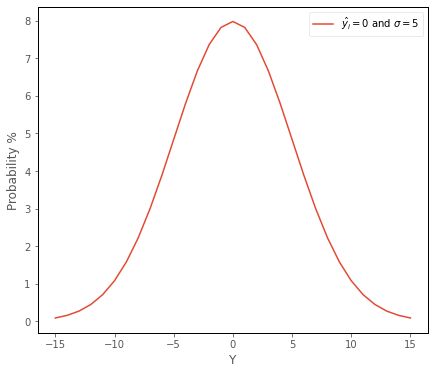

In [4]:
# plot a normal distribution, using the function defined above
y = np.arange(-15,16)
prob = normal_pdf(y, 0, 5)
plt.plot(y,prob*100, label = r"$\hat{y_i} = 0 $ and $\sigma = 5$") 
islands_GLM.normal_labels()

We can see that randomly sampling scores around the mean is more probable than scores in the tails of the distribution, far from the mean.

The cell below re-runs the function, and this time also shows the probability of obtaining each score ranging from -15 to 15 if randomly sampling from a normal distribution with  mean of -5 and a variance of 5 (this graph is shown in blue):

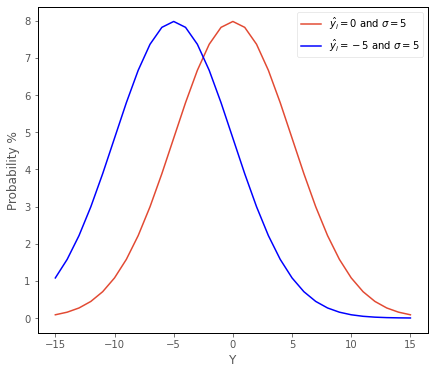

In [5]:
# also plot a normal distribution with different parameters
y = np.arange(-15,16)
prob = normal_pdf(y, 0, 5)
plt.plot(y,prob*100, label = r"$\hat{y_i} = 0 $ and $\sigma = 5$") 
prob = normal_pdf(y, -5, 5)
plt.plot(y,prob*100, color = 'blue', label = r"$\hat{y_i} = -5 $ and $\sigma = 5$") 
islands_GLM.normal_labels();

We can see that as we vary the parameters ($\hat{y_i}$ and $\sigma$) the probability of getting a given score changes. Scores closer to -5 are more probable if sampling from a normal distribution with a mean of -5, than if randomly sampling from a normal distribution with a mean of 0.

The graph below shows the effect of applying this functon, with a variety of different $\hat{y_i}$ and $\sigma$ pairings:

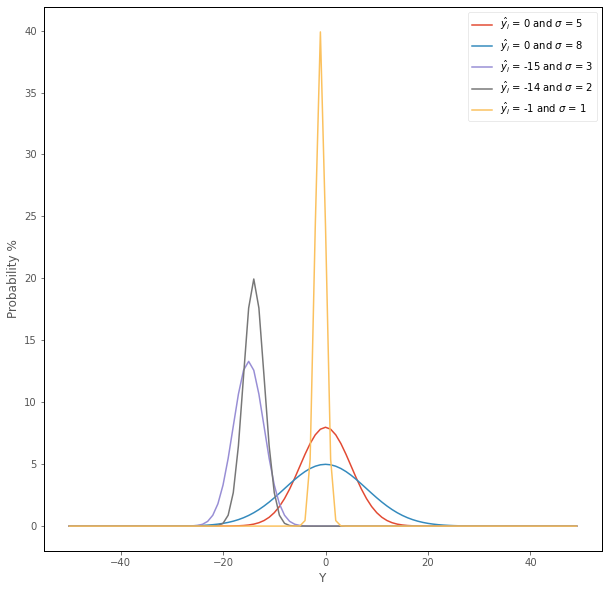

In [6]:
# this code generates the plot below
islands_GLM.normal_plot()

As we saw on the ['What are Generalized Linear Models?'](1_generalized_linear_models.ipynb) page, linear regression involves fitting a set of conditional normal distributions to the outcome data, as a function of the predictor variables. This is shown again in the image below:

![](images/GLM_normal_identity.png)

(Image from: https://blogs.sas.com/content/iml/2015/09/10/plot-distrib-reg-model.html)

The likelihood function shown above fits these conditional normal distributions to the data. The likelihood function allows the mean ($\hat{y}_i$) of each normal distribution to vary as a function of the predictor variables ($\hat{y}_i = b_0 + b_1x_{1i} ... + b_kx_{ki})$. The function takes the dataset (the predictor scores and outcome scores), and two parameters ($\hat{y_i}$ and $\sigma$) and computes the likelihood of obtaining the outcome scores, conditional on the predictor scores and those particular parameters. (NB: $\hat{y_i}$ is a vector containing each of the predictions from the linear prediction equation, for a given intercept/slope set).

By finding the values of of $b_0$,  $b_k$ and $\sigma$ which maximize the likelihood function (e.g. values of of $b_0$,  $b_k$ and $\sigma$ which yield a higher value of the function than any other values of of $b_0$,  $b_k$ and $\sigma$), we find the set of linearly positioned normal distributions which best fit the data. It is because $\hat{y_i}$ is obtained from the linear prediction equation, that the normal distributions which are fit to the data fall on a straight line.

Because maximizing the likelihood formula involves multiplying together probabilities, the numbers can get very small very quickly, and this can lead to computational errors. In practice, we get around this by minimizing the *negative log-likelihood*, rather than maximizing the likelihood directly. This produces the same parameter estimates, but is less prone to numerical errors. The negative log-likelihood formula is: 

$ \huge \frac{n}{2} \ln(2\pi\sigma^{2}) +  \frac{{\sum\limits_{i = 1}^{n}(y_{i} - \hat{y_{i}})^{2}}}{2\sigma^{2}}$

This formula is just the result of applying the log transformation to the likelihood formula shown earlier. It is also referred to as the *cost function*, as we want it to be *cheap* e.g. we want to find the parameter values that yield it's minimum possible value.

## Implementation

The python cell below defines a function which uses the negative log-likelihood formula just shown to calculate the negative log likelihood for a given set of parameters ($b_0,$ $b_1$, $\sigma$) for a given dataset (a vector of outcome $y_i$ values and a vector of predictor $x_i$ values):

In [7]:
# this code defines a function which implements the negative log-likelihood function for linear regression
def lin_reg_neg_likelihood(intercept_slope_sigma, predictor, outcome):
  
    intercept, slope, sigma = intercept_slope_sigma[0], intercept_slope_sigma[1], intercept_slope_sigma[2]

    y_hat = intercept + slope * predictor
    
    y = outcome

    n = len(y)

    output =  n/2 * np.log(2 * np.pi * sigma**2) + np.sum((y - y_hat)**2)/(2*sigma**2)

    return output

The python cell below tests the the negative log likelihood function with the parameters: 

$b_0$ = 1

$b_1$ = 1 

$\sigma$ = 1

for the `prestige ~ wealth` data, with `wealth` as the predictor and `prestige` as the outcome:

In [8]:
# testing the negative log-likelihood function defined above
lin_reg_neg_likelihood([1,1,1], df['wealth'], df['prestige'])

101943530.8938332

The maximum likelihood estimates can be found via calculus, by finding the parameter values which give the global minimum of the negative log-likelihood function. Using python, we can pass the cost function, and a set of parameters, to the [minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) function, from the [SciPy](https://scipy.org/) library to find the parameters which give the global minimum of the cost function. The `minimize` function will try various sets of parameters until it finds the parameters which give the lowest value of the function:

In [9]:
# finding the paramter values that minimize the negative log-likelihood function
minimize(lin_reg_neg_likelihood, [1,1,1],  args = ( df['wealth'], df['prestige'])).x

array([-62.98373952,   4.00515213,  60.9655072 ])

The values in the array above are (in order) the intercept, slope and sigma value which give the lowest negative loglikelihood, and are the parameters which give the line of normal distributions which best fit the data:

![](images/GLM_normal_identity.png)

(Image from: https://blogs.sas.com/content/iml/2015/09/10/plot-distrib-reg-model.html)

The graph below shows a line generated using this slope and intercept, alongside the data:

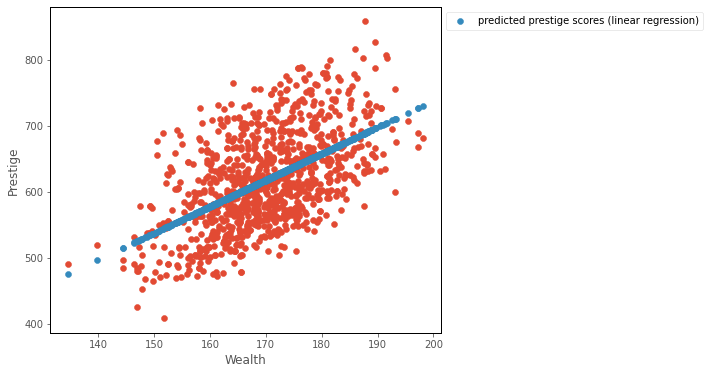

In [10]:
# this code generates the plot below
intercept, slope, sigma = minimize(lin_reg_neg_likelihood, [1,1,1],  args = ( df['wealth'], df['prestige'])).x
islands_GLM.plot_prestige_wealth_with_prediction(df['wealth'], df['prestige'], intercept + slope * df['wealth']);

The cell below shows again the parameter estimates obtained from minimizing the cost function using `minimize`. The second cell below fits a linear regression with `statsmodels`, the parameter estimates are shown in the `coef` section of the regression table below the cell:

In [11]:
# finding the paramter values that minimize the negative log-likelihood function
minimize(lin_reg_neg_likelihood, [1,1,1],  args = ( df['wealth'], df['prestige'])).x

array([-62.98373952,   4.00515213,  60.9655072 ])

In [12]:
# fitting a linear regression model using statsmodels
mod = smf.ols('prestige ~ wealth', data = df).fit()

# show the regression table
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               prestige   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     403.8
Date:                Wed, 06 Jul 2022   Prob (F-statistic):           1.08e-75
Time:                        21:02:55   Log-Likelihood:                -5529.2
No. Observations:                1000   AIC:                         1.106e+04
Df Residuals:                     998   BIC:                         1.107e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -62.9928     33.908     -1.858      0.063    -129.531       3.546
wealth         4.0052      0.199     20.096      0.000       3.614       4.396
==============================================================================
Omnibus:                       50.454   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.067
Skew:                           0.455   Prob(JB):                     1.64e-10
Kurtosis:                       2.498   Cond. No.                     2.99e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.99e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We can see that the parameter values obtained by minimizing the negative log-likelihood function are identical to the parameter estimates we get from carrying out a linear regression using the [statsmodels](https://www.statsmodels.org/stable/index.html) library.

## Interpretation (one predictor model)

Note: the intercept and slope are shown under the `coef` heading in the regression table above, the associated $p$-values are shown under `P>|z|`.

The intercept value tells us the predicted value of the outcome (`prestige`) for a predictor (`wealth`) score of 0. This may or may not be a meaningful prediction, depending on the dataset and how many very low values of the predictor are actually observed (a lot of extrapolation is going on there are not many observations with low predictor scores!). The $p$-value for the intercept tells us how (un)likely it would be to obtain an intercpet of the value we obtained, if randomly sampling from a population where the true intercept was 0.

The slope tells us the expected in increase in the outcome for a 1 unit change in the predictor. In this case, based on this dataset, we expect a 4 unit increase in `prestige` for a 1 unit increase in `wealth`. The $p$-values for the predictor tell us how (un)likely it would be, under repeated random sampling, to observe a slope of the size we observed if the population slope was zero. 


## Linear Regression with multiple predictors

In more than two dimensions, linear regression fits a (hyper)plane, rather than a line, to the data.

The graph below shows a hypothetical multiple regression model fit to an outcome with two continuous predictor variables. The blue surface is the linear regression model, the red dots are the hypothetical data points:

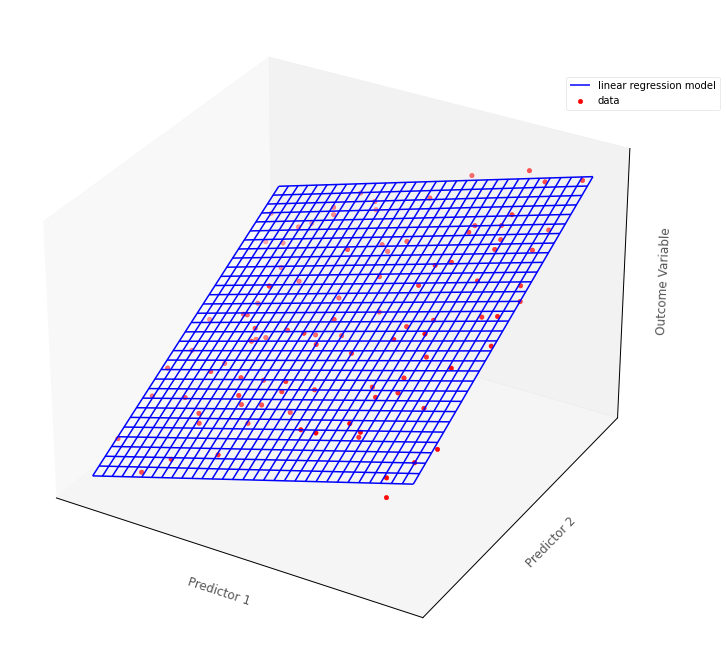

In [13]:
# this code generates the plot below
islands_GLM.three_D_lin_reg_plot()

Generalized linear models, of which linear regression is a special case, are a flexible framework that allow for all types of predictor variable. Returning to the data from the current island, let's say your research team is also interested in investigating whether religious group membership is also associated with `prestige`. 

There are two major religions on the island, so membership of either can be indicated with a 0 or a 1 (`0 = religion A`, `1 = religion B` or vice versa). Religious group membership was recorded during data collection, and a dataframe whcih also shows the variable `religion` is below:

In [14]:
# show the dataframe
df

,wealth,religion,prestige
0,181.35,1,641
1,178.62,1,652
2,176.06,0,689
3,190.41,1,632
4,166.84,0,635
...,...,...,...
995,168.00,1,558
996,165.21,1,544
997,139.76,0,519
998,168.80,1,525


The graph below shows a 2D scatterplot which depicts `wealth`, `prestige` and `religion`:

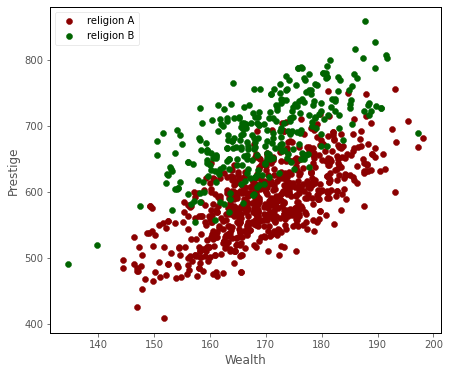

In [15]:
# this code just generates the plot below
islands_GLM.plot_prestige_wealth_with_religion(df)

From graphical inspection, it does appear that the religious groups might differ in their average prestige. Because of what [John Fox](https://us.sagepub.com/en-us/nam/applied-regression-analysis-and-generalized-linear-models/book237254) calls the 'geometric trick' of using indicator variables, we can also show the data in a 3D data-space. Because of the dummy coding (`1 = religion A`, `0 = religion B`), all of the datapoints line up at either 0 or 1 on one of the axes, rather than being distributed all along the axis, as they are with the continuous predictor:

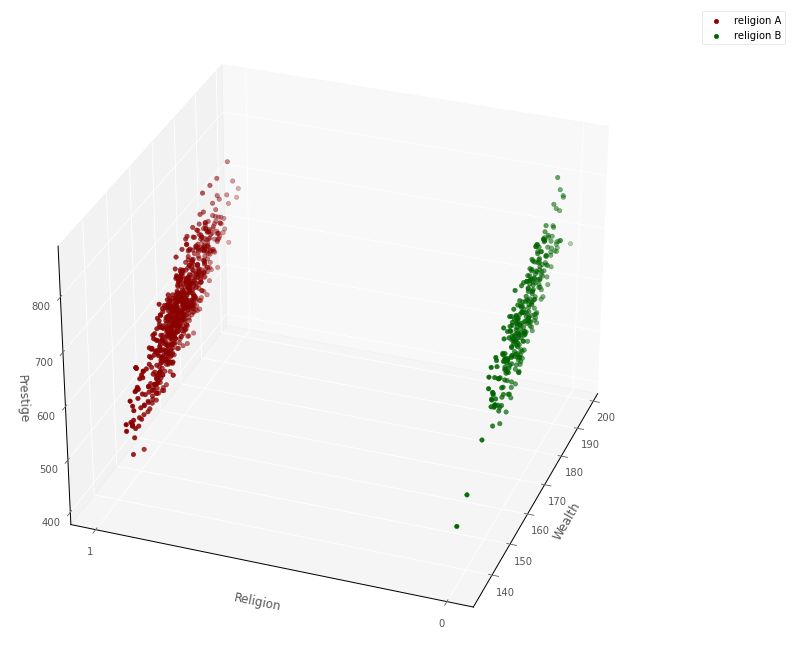

In [16]:
# this code generates the plot below
islands_GLM.three_D_prestige_wealth_religion_plot(df, azim = 200)

I'll fit a regression model using `statsmodels`, and then use this 3D space to show the regression model alongside the data.

The regression model will mode `prestige` as a linear function of `religion` and `wealth`, so the model is - `prestige ~ religion + wealth`:

In [17]:
# fit a linear regression model with statsmodels
lin_reg_model = smf.ols('prestige ~ religion + wealth', data = df).fit()

# show the regression table
lin_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               prestige   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     1094.
Date:                Wed, 06 Jul 2022   Prob (F-statistic):          3.72e-252
Time:                        21:02:59   Log-Likelihood:                -5118.5
No. Observations:                1000   AIC:                         1.024e+04
Df Residuals:                     997   BIC:                         1.026e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.1766     22.590      0.450      0.652     -34.153      54.506
religion     -99.6753      2.797    -35.640      0.000    -105.163     -94.187
wealth         3.9858      0.132     30.142      0.000       3.726       4.245
==============================================================================
Omnibus:                       14.181   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                9.726
Skew:                           0.108   Prob(JB):                      0.00773
Kurtosis:                       2.568   Cond. No.                     3.00e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  3e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Here is the `prestige ~ religion + wealth` linear regression model shown in 3D dataspace, along with the raw data:

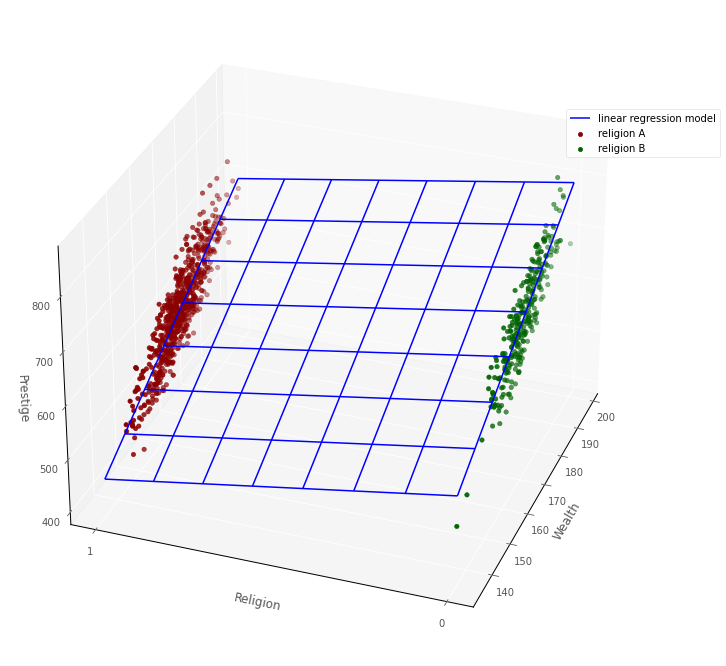

In [18]:
# this code generates the plot below
islands_GLM.three_D_prestige_wealth_religion_plot_with_surface(df, lin_reg_model, azim = 200)

The above graph shows the 'geometric trick' mentioned earlier: because `religion` is an indicator variable defined only at 0 or 1, all of the datapoints fall at either 0 or 1. But the regression surface covers the space between 0 and 1, this allows us to use the linear regression model with categorical predictors.

## Interpretation (multiple predictors)

How do we interpret the linear regression model parameter estimates, when there are multiple predictors?

Note: the intercept and slopes are shown under the `coef` heading in the regression table above, the associated $p$-values are shown under `P>|z|`.

The intercept tells us the predicted score on the outcome variable for an observation whose score on all other predictors was 0. The $p$-value for the intercept tells us how (un)likely it would be to obtain an intercpet of the value we obtained, if randomly sampling from a population where the true intercept was 0.

The slope of each predictor tells us the predicted difference in the outcome variable scores for two hypothetical observations which differed *only* by a one unit score in that predictor. E.g. which had the same score on all other predictors. Sometimes this is referred to as *statistical control*. We might say each slope tells us the estimated change in the outcome for a 1 unit increase in that predictor, *controlling* for other predictors in the model. 

This 'statistical control' interpretation of the slopes s is easy to explain via the graph above (the graph showing the linear regression surface and the datapoints). If we 'hold `religion` constant' by looking only at the graph where `religion = 1`, then we compare points where `wealth` varies, the regression surface let's us predict the change in `prestige` as a function of wealth, whilst 'controlling for' (e.g. holding constant) `religion`. Obviously, the validity of this interpretation depends on how well the [assumptions of the linear regression model](https://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/R/R5_Correlation-Regression/R5_Correlation-Regression4.html#:~:text=There%20are%20four%20assumptions%20associated,are%20independent%20of%20each%20other) are met...

The $p$-values for each predictor tell us how (un)likely it would be, under repeated random sampling, to observe a slope of the size we observed if the population slope was zero.

## Statistical interaction in Linear Regression

The definition of statistical interaction is: the influence of a predictor on the outcome variable depends on the value of some other predictor(s).

If we fit an interaction term in linear regression this involves taking the cross product of two predictors. So if the we wanted to look for an interaction between $x_1$ and $x_2$ we would include $x_1 * x_2$ as a predictor in the model. So the model would be:

$\large \hat{y}_i = b_0 + b_1x_{1i} + b_2x_{2i}...  + b_kx_{1i}x_{2i}  $

Geometrically, this allows the linear regression surface to 'bend', so that the effect of the predictors is not constant, but depends on the value of the other predictor. This is shown on the graph below:

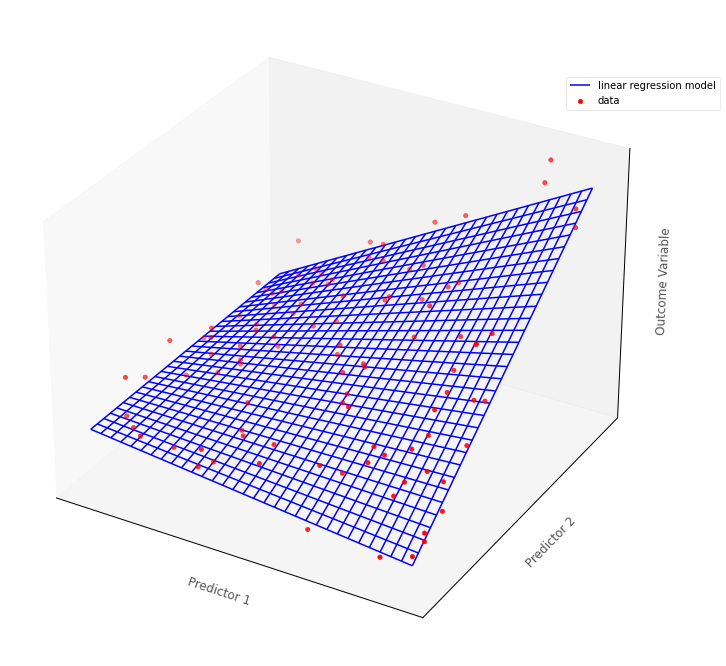

In [19]:
# this code generates the plot below
islands_GLM.three_D_lin_reg_plot(interaction = True)

That's it for linear regression from the conditional distribution/maximum likelihood perspective. You can visit another page/island via the links in the table of contents, and at the bottom of this page...

***
By [pxr687](99_about_the_author.ipynb) 